In [1]:
using Pkg
Pkg.activate("../scripts/cal-val/")
using CairoMakie
using IceFloeTracker
using DataFrames
using Images
using CSV

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val`


In [2]:
include("../scripts/dev/validation_data.jl")

_get_file (generic function with 1 method)

In [3]:
data_loader = Watkins2025GitHub(; ref="25ba4d46814a5423b65ad675aaec05633d17a37e")
dataset = data_loader(c-> c.case_number == 63)
cases = [x for x in dataset.data]
if occursin("terra", cases[1].name)
    terra = cases[1]
    aqua = cases[2]
else
    aqua = cases[1]
    terra = cases[2]
end
nothing

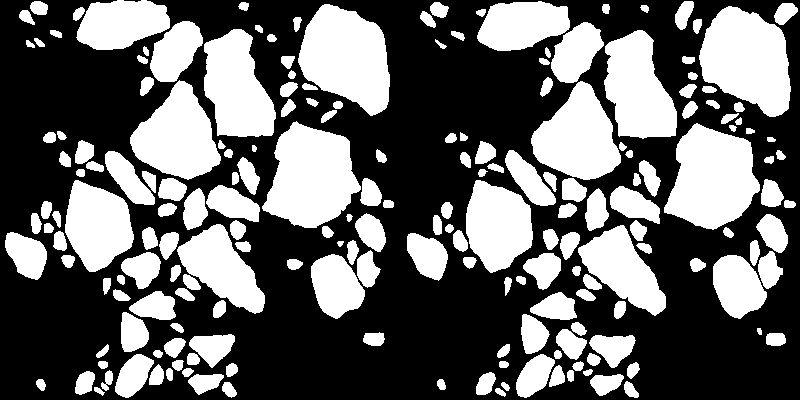

In [4]:
mosaicview(terra.validated_binary_floes, aqua.validated_binary_floes, nrow=1)

Goal: Figure showing the steps of the tracker.
1. Pair of images
2. Selection with distance threshold
3. 

In [5]:
# # Set thresholds from file
# mc_thresholds = IceFloeTracker.mc_thresholds

# # Alternatively load the defaults:
# # condition_thresholds = IceFloeTracker.condition_thresholds
# ct = (search_thresholds = 
#         (dt = (30.0, 100.0, 1300.0),
#          dist = (200, 250, 300)),
#       small_floe_settings = (minimumarea = 100,
#                              arearatio = 0.18,
#                              majaxisratio = 0.1,
#                              minaxisratio = 0.15,
#                              convexarearatio = 0.2),
#       large_floe_settings = (minimumarea = 1200,
#                              arearatio = 0.28,
#                              majaxisratio = 0.1,
#                              minaxisratio = 0.12,
#                              convexarearatio = 0.14))

In [5]:
aqua.metadata[:pass_time], terra.metadata[:pass_time]

(DateTime("2007-07-11T19:26:11"), DateTime("2007-07-11T20:44:14"))

In [278]:
Second(terra.metadata[:pass_time] - aqua.metadata[:pass_time])

4683 seconds

In [6]:
# Extract pass times from the metadata
# passtimes = [terra.metadata[:pass_time], aqua.metadata[:pass_time] + Day(1)] # Exaggerate time step to test matching algorithm
passtimes = [terra.metadata[:pass_time], aqua.metadata[:pass_time]] # True time delta

2-element Vector{DateTime}:
 2007-07-11T20:44:14
 2007-07-11T19:26:11

In [7]:

if aqua.metadata[:pass_time] < terra.metadata[:pass_time]
    order = ["aqua", "terra"]
    labeled_images = [aqua.validated_labeled_floes.image_indexmap,
                  terra.validated_labeled_floes.image_indexmap]
else
    order = ["terra", "aqua"]
    labeled_images = [terra.validated_labeled_floes.image_indexmap,
                  aqua.validated_labeled_floes.image_indexmap]
end
props = IceFloeTracker.regionprops_table.(labeled_images);

In [281]:
using Dates: seconds
abstract type AbstractTimeDistanceThresholdFunction end

@kwdef struct LogLogQuadraticTimeDistanceFunction <: AbstractTimeDistanceThresholdFunction
    llq_params=[0.403, 0.988, -0.05]
    min_time=Hour(1)
    max_time=Day(7)
    # TODO: add tests of input types and dimensions
    # TODO: potentially move the parameterized equation into the struct
end

function (f::LogLogQuadraticTimeDistanceFunction)(Δx, Δt)
    a, b, c = f.llq_params
    seconds(Δt) > seconds(f.max_time) && return false
    
    Δx_km = Δx / 1000
    seconds(Δt) <= seconds(f.min_time) && return Δx_km <= 10^a # Check whether this is being activated early. Issue with time format?
    
    Δt_hours = seconds(Δt) / 3600
    Δx_km <= 10^(a + b * log10(Δt_hours) + c * (log10(Δt_hours))^2) && return true
    return false
end

# Could add a method to return the distance actually (representing a 99th percentile of distance by time)
distance_threshold_function = LogLogQuadraticTimeDistanceFunction()

LogLogQuadraticTimeDistanceFunction([0.403, 0.988, -0.05], Hour(1), Day(7))

In [9]:
abstract type AbstractGeometricThresholdFunction end

# how does kwdef work with named tuples? I'm guessing all the settings would need to be set at once.
@kwdef struct LopezAcostaAbsDiffThresholdFunction <: AbstractGeometricThresholdFunction
    small_floe_settings = (
            minimumarea=100, # Temporarily set to 100. Set to 700 for the actual default, since that's what's in the paper. 
            majaxisratio=0.07,
            minaxisratio=0.08,
            arearatio=0.18,
            convexarearatio=0.09,
            )
    large_floe_settings = (
            minimumarea=1200, # 75 km2
            maximumarea=15e3, # 940 km2
            majaxisratio=0.10,
            minaxisratio=0.12,
            arearatio=0.28,
            convexarearatio=0.14,
        )
end

"""LopezAcostaAbsDiffThresholdFunction(area, adr_area, adr_convex_area, adr_majoraxis, adr_minoraxis)

Implementation of the area-dependent absolute difference ratio threshold test defined in Lopez-Acosta et al. 2019.
Floes smaller than the small floe settings `minimumarea` parameter are rejected. Floes between the small floe and
large floe `minimumarea` are tested against the `small_floe_settings` ratio thresholds; floes larger than the large
floe settings `minimumarea` are tested against the `large_floe_settings` minimum thresholds. See the `compute_ratios`
function for the implementation of the absolute difference ratios.
"""
function (f::LopezAcostaAbsDiffThresholdFunction)(area, adr_area, adr_convex_area, adr_majoraxis, adr_minoraxis)
    area < f.small_floe_settings.minimumarea && return false
    area > f.large_floe_settings.maximumarea && return false
    area < f.large_floe_settings.minimumarea ? (settings = f.small_floe_settings) : (settings = f.large_floe_settings)

    return adr_area < settings.arearatio &&
           adr_majoraxis < settings.majaxisratio &&
           adr_minoraxis < settings.minaxisratio &&
           adr_convex_area < settings.convexarearatio
end


@kwdef struct LopezAcostaShapeDifferenceThresholdFunction <: AbstractGeometricThresholdFunction
    small_floe_settings = (
        minimumarea=100,
        shapedifference=0.18
        )
    large_floe_settings = (
        minimumarea=1200,
        shapedifference=0.24
        )
end


# shape-difference threshold function
"""
Area-dependent threshold test for normalized shape difference, where the minimum shape difference
after rotation is normalized by the area of the first floe.
"""
function (f::LopezAcostaShapeDifferenceThresholdFunction)(area, normalized_shape_difference)
    area < f.large_floe_settings.minimumarea ? (settings = f.small_floe_settings) : (settings = f.large_floe_settings)
    return normalized_shape_difference < settings.shapedifference
end

# psi-s curve threshold is set the same for all floe sizes

"""
The piecewise linear threshold function is defined using two (area, value) pairs. For
areas below the minimum area, it is constant at minimum value; likewise for above the
maximum area. The threshold function is linear in between these two points.
"""
@kwdef struct PiecewiseLinearThresholdFunction <: AbstractGeometricThresholdFunction
    minimum_area = 100
    maximum_area = 700
    minimum_value = 0.4
    maximum_value = 0.2
end

function (f::PiecewiseLinearThresholdFunction)(area, value)
    area < f.minimum_area && return value < f.minimum_value
    area > f.maximum_area && return value < f.maximum_value
    slope = (f.maximum_value - f.minimum_value) / (f.maximum_area - f.minimum_area)
    return slope*(area - f.maximum_area) + f.maximum_value
end

In [10]:
# Old settings
f = LopezAcostaShapeDifferenceThresholdFunction()

# New functions
adr_area_threshold = PiecewiseLinearThresholdFunction(100, 700, 0.27, 0.18) 
adr_convex_area_threshold = PiecewiseLinearThresholdFunction(100, 700, 0.27, 0.17)
adr_major_axis_threshold = PiecewiseLinearThresholdFunction(100, 700, 0.16, 0.12)
adr_minor_axis_threshold = PiecewiseLinearThresholdFunction(100, 700, 0.20, 0.12)
scaled_shape_difference_threshold = PiecewiseLinearThresholdFunction(100, 700, 0.50, 0.32)
psi_s_corr_threshold = PiecewiseLinearThresholdFunction(100, 700, 0.84, 0.89)

# These are just the ones for matched pairs, check the rotation ones for psi-s
# Small adr_major_axis_length     99% 0.16 95% 0.13 n= 292
# Large adr_major_axis_length     99% 0.12 95% 0.06 n= 72
# Small adr_minor_axis_length     99% 0.2 95% 0.15 n= 292
# Large adr_minor_axis_length     99% 0.12 95% 0.07 n= 72
# Small adr_area                  99% 0.27 95% 0.21 n= 292
# Large adr_area                  99% 0.18 95% 0.08 n= 72
# Small adr_convex_area           99% 0.27 95% 0.21 n= 292
# Large adr_convex_area           99% 0.17 95% 0.1 n= 72
# Small normalized_shape_difference 99% 0.5 95% 0.41 n= 292
# Large normalized_shape_difference 99% 0.32 95% 0.25 n= 72
# Small psi_s_correlation         99% 0.16 95% 0.08 n= 292
# Large psi_s_correlation         99% 0.11 95% 0.04 n= 72



# Try setting these up as a list of column names and functions - organization?

PiecewiseLinearThresholdFunction(100, 700, 0.84, 0.89)

In [294]:
greaterthan0(x) = x .> 0
IceFloeTracker.addfloemasks!(props, greaterthan0.(labeled_images));
IceFloeTracker.add_passtimes!(props, passtimes);
IceFloeTracker.addψs!(props);
IceFloeTracker.adduuid!(props);

# Identifying true matches
We have some data with the true matches in the validation folder; there are also a few cases with lots of floes that we can identify matches based on maximal overlap.

## Functions to write
- add label

In [183]:
aqua.

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,mask,passtime,psi,uuid
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,BitMatrix,DateTime,Array…,String
1,1062.0,323,363,364,397,342,381,1136.0,43.1141,32.627,0.267879,129.983,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],2022-05-30T16:44:44,"[5.1762, 5.1638, 5.18932, 4.69882, 4.7117, 4.72214, 4.22025, 4.75835, 4.26279, 5.18366 … 9.39092, 9.93195, 9.82563, 9.44311, 9.9188, 9.83686, 9.91372, 10.1965, 10.5348, 10.9894]",QzWGdtj6WVdT


In [164]:
IceFloeTracker.corr(props[1][1, :psi], props[2][10, :psi])

0.9792713952406644

In [165]:
using Statistics

In [299]:
function match_nearest(
        tracked::T,
        candidates::T; max_distance = 1e3) where {T<:AbstractDataFrame}
    
    matches = []
    # Filter the candidate list step by step. If any candidate floes pass all the thresholds, add them to the potential match list.
    for floe1 in eachrow(tracked)
        candidate_subset = deepcopy(candidates)
        candidate_subset[:, :floe1_uuid] .= floe1.uuid

        # distance test
        candidate_subset[!, :Δt] = candidate_subset[!, :passtime] .- floe1.passtime
        candidate_subset[!, :Δx] = euclidean_distance(floe1, candidate_subset)
        subset!(candidate_subset, [:Δx] => ByRow(r -> r < max_distance))
        
        nrow(candidate_subset) == 0 && continue    

        # Add geometric ratio data without subsetting
        floe1_ratios(r) = compute_ratios(floe1, r)
        ratio_df = floe1_ratios.(eachrow(candidate_subset)) |> DataFrame
        rename!(n -> "adr_"*n, ratio_df)
        candidate_subset = hcat(candidate_subset, ratio_df)
        
        # Add shape difference data without subsetting
        function floe1_normalized_shape_difference(r)
            results = IceFloeTracker.shape_difference_rotation(floe1[:mask], r[:mask], range(; start=-π/2, stop=π/2, step=π/90))
            shape_diff = last.(results)
            return minimum(shape_diff) / floe1[:area]
        end

        candidate_subset[:, :normalized_shape_difference] = floe1_normalized_shape_difference.(eachrow(candidate_subset))
        
        # psi-s curve
        # option for update: return the confidence interval based on the length of the shorter perimeter
        function floe1_psi_s_comp(r)
            pearson_corr, lags = IceFloeTracker.crosscorr(floe1[:psi], r[:psi]; normalize=true, padmode=:none);    
            return maximum(pearson_corr)
        end
        candidate_subset[:, :psi_s_correlation] = floe1_psi_s_comp.(eachrow(candidate_subset))
        
        append!(matches, eachrow(candidate_subset))
    end
    return DataFrame(matches)
end

nearest_match = match_nearest(props[1], props[2]; max_distance = 4.5e3);
# First find the closest from floe1 -> match
nearest_match = combine(sdf -> sdf[argmin(sdf.Δx), :], groupby(nearest_match, :floe1_uuid));
# Then if there are multiple matches to the same floe, select the one that is closest again
nearest_match = combine(sdf -> sdf[argmin(sdf.Δx), :], groupby(nearest_match, :uuid));


nearest_match[:, :dxdt] = abs.(nearest_match[:, :Δx] ./ [x.value for x in Second.(nearest_match[:, :Δt])]);
umean = mean(nearest_match.dxdt)
ustd = std(nearest_match.dxdt)
subset!(nearest_match, :dxdt => ByRow(r -> (r - umean)/ustd < 3));

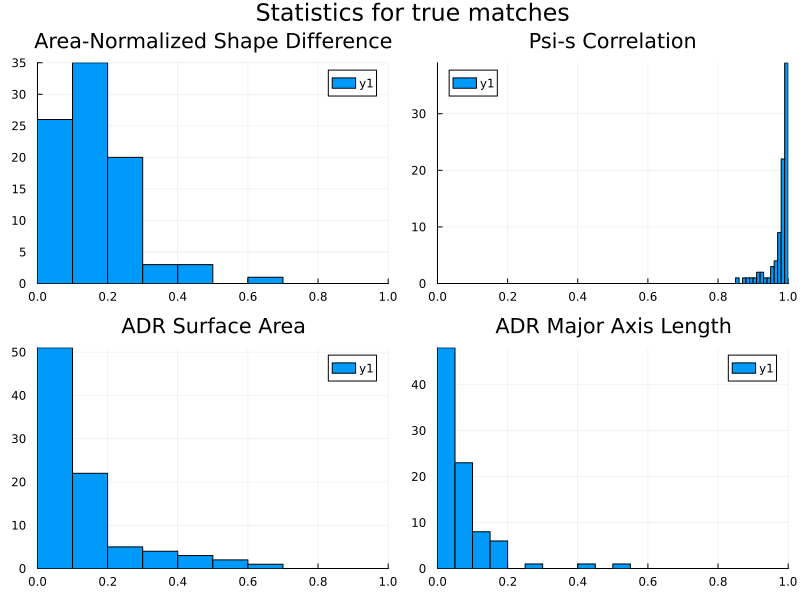

In [300]:
Plots.plot(
    Plots.histogram(nearest_match[:, :normalized_shape_difference], title="Area-Normalized Shape Difference", xlim=(0, 1)),
    Plots.histogram(nearest_match[:, :psi_s_correlation], title="Psi-s Correlation", xlim=(0, 1)), 
    Plots.histogram(nearest_match[:, :adr_area], title="ADR Surface Area", xlim=(0, 1)),
    Plots.histogram(nearest_match[:, :adr_majoraxis], title="ADR Major Axis Length", xlim=(0, 1)), size=(800, 600),
    suptitle="Statistics for true matches")

In [268]:
LopezAcostaAbsDiffThresholdFunction()

LopezAcostaAbsDiffThresholdFunction((minimumarea = 100, majaxisratio = 0.07, minaxisratio = 0.08, arearatio = 0.18, convexarearatio = 0.09), (minimumarea = 1200, maximumarea = 15000.0, majaxisratio = 0.1, minaxisratio = 0.12, arearatio = 0.28, convexarearatio = 0.14))

In [ ]:
# First find the closest from floe1 -> match
test_matches = combine(sdf -> sdf[argmin(sdf.Δx), :], groupby(nearest_match, :floe1_uuid));
# Then if there are multiple matches to the same floe, select the one that is closest again
test_matches = combine(sdf -> sdf[argmin(sdf.Δx), :], groupby(test_matches, :uuid));

gdf = groupby(test_matches, :floe1_uuid)
combine(gdf, nrow)


In [174]:
# Euclidean distance from pixel data with fixed resolution r
# Inputs are a single row x and a DataFrame Y
euclidean_distance(x, Y; r = 250) = sqrt.((x.row_centroid .- Y.row_centroid).^2 .+ (x.col_centroid .- Y.col_centroid).^2) * r

euclidean_distance (generic function with 1 method)

In [175]:
using IceFloeTracker: getcentroid

In [176]:
adr_function = LopezAcostaAbsDiffThresholdFunction()

LopezAcostaAbsDiffThresholdFunction((minimumarea = 100, majaxisratio = 0.07, minaxisratio = 0.08, arearatio = 0.18, convexarearatio = 0.09), (minimumarea = 1200, maximumarea = 15000.0, majaxisratio = 0.1, minaxisratio = 0.12, arearatio = 0.28, convexarearatio = 0.14))

# Developing a floe-matching functor

With the functor approach, we have the track_floes function taking a list of property tables as an input and keeping track of trajectory heads and candidate floes. Then we have a floe pairing function that looks at the relations between just two sets: trajectory heads, candidates. 

TBD: if there are no floes within k days of the current set, we don't need to call the matching function, and we assign all of the floes as trajectory heads.




In [177]:
using IceFloeTracker: compute_ratios

In [331]:
using IceFloeTracker: compute_ratios
# assumes that the max dt filter is applied before find floe matches is called
# since that should be handled in selection of relevant trajectory heads
# Potential inputs:
# Distance threshold function
# Geometric threshold function
# Shape Difference threshold function
# Psi-S threshold function
# MatchSelector function

# New settings from 99percentile method

minimum_area = 64
breakpoint_area = 700
maximum_area = 25600

updated_adr_function = LopezAcostaAbsDiffThresholdFunction(
    small_floe_settings = (
            minimumarea=minimum_area, # approx 2 km length scale
            majaxisratio=0.24,
            minaxisratio=0.22,
            arearatio=0.37,
            convexarearatio=0.38,
            ),
    large_floe_settings = (
            minimumarea=breakpoint_area, # approx 7 km length scale
            maximumarea=maximum_area, # approx 65 km length scale
            majaxisratio=0.12,
            minaxisratio=0.10,
            arearatio=0.13,
            convexarearatio=0.13,
        ))

updated_sd_function = LopezAcostaShapeDifferenceThresholdFunction(
    small_floe_settings = (
        minimumarea=minimum_area,
        shapedifference=0.75
        ),
    large_floe_settings = (
        minimumarea=breakpoint_area,
        shapedifference=0.29
        ))

function updated_correlation_function(area, r; small_floe_threshold=0.84, large_floe_threshold=0.94)
    area < minimum_area && return false
    area > maximum_area && return false
    area < breakpoint_area && return r > small_floe_threshold
    return r > large_floe_threshold
end

function updated_find_floe_matches(
        tracked::T,
        candidates::T;
        distance_threshold_function = LogLogQuadraticTimeDistanceFunction(),
        ratio_threshold_function = updated_adr_function,
        shape_difference_function = updated_sd_function,
        psi_s_comparison_function = updated_correlation_function,
        ) where {T<:AbstractDataFrame}
    
    matches = []
    # Filter the candidate list step by step. If any candidate floes pass all the thresholds, add them to the potential match list.
    for floe1 in eachrow(tracked)
        candidate_subset = deepcopy(candidates)
        candidate_subset[:, :floe1_uuid] .= floe1.uuid

        # distance test
        candidate_subset[!, :Δt] = candidate_subset[!, :passtime] .- floe1.passtime
        candidate_subset[!, :Δx] = euclidean_distance(floe1, candidate_subset)
        subset!(candidate_subset, [:Δx, :Δt] => ByRow(distance_threshold_function))
        
        # if no rows remain, move to the next trajectory head
        nrow(candidate_subset) == 0 && continue
            
        # geometric ratio tests
        floe1_ratios(r) = compute_ratios(floe1, r)
        ratio_df = floe1_ratios.(eachrow(candidate_subset)) |> DataFrame
        rename!(n -> "adr_"*n, ratio_df)
        candidate_subset = hcat(candidate_subset, ratio_df)
        subset!(candidate_subset, [:area, :adr_area, :adr_convex_area, :adr_majoraxis, :adr_minoraxis] => ByRow(ratio_threshold_function))
        nrow(candidate_subset) == 0 && continue    

        # shape difference metric
        # option for update: normalize by the number of boundary pixels since shape difference scales with the boundary length
        function floe1_normalized_shape_difference(r)
            results = IceFloeTracker.shape_difference_rotation(floe1[:mask], r[:mask], range(; start=-π/2, stop=π/2, step=π/90))
            shape_diff = last.(results)
            return minimum(shape_diff) / floe1[:area]
        end

        candidate_subset[:, :normalized_shape_difference] = floe1_normalized_shape_difference.(eachrow(candidate_subset))
        subset!(candidate_subset, [:area, :normalized_shape_difference] => ByRow(shape_difference_function))
        nrow(candidate_subset) == 0 && continue    
        
        # psi-s curve
        # option for update: return the confidence interval based on the length of the shorter perimeter
        function floe1_psi_s_comp(r)
            pearson_corr, lags = IceFloeTracker.crosscorr(floe1[:psi], r[:psi]; normalize=true, padmode=:none);    
            return maximum(pearson_corr)
        end
        candidate_subset[:, :psi_s_correlation] = floe1_psi_s_comp.(eachrow(candidate_subset))
        subset!(candidate_subset, [:area, :psi_s_correlation] => ByRow(psi_s_comparison_function))

        nrow(candidate_subset) == 0 && continue    
        append!(matches, eachrow(candidate_subset))
    end     
    return DataFrame(matches) # this has all the measures for each pair, which we can convert into weights or similarity scores for the final matching
end

updated_find_floe_matches (generic function with 1 method)

In [332]:
default_test_matches = updated_find_floe_matches(props[1], props[2]);

In [333]:
default_test_matches

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,mask,passtime,psi,uuid,floe1_uuid,Δt,Δx,adr_area,adr_majoraxis,adr_minoraxis,adr_convex_area,normalized_shape_difference,psi_s_correlation
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,BitMatrix,DateTime,Array…,String,String,Millisec…,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3516.0,1,77,50,170,24,122,3693.0,95.5163,47.8655,-1.38696,252.167,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],2007-07-11T19:26:11,"[5.17196, 4.72574, 5.17378, 5.15621, 4.71761, 4.71289, 4.71326, 4.7259, 4.21052, 4.72976 … 11.0964, 10.4977, 11.0094, 10.9964, 10.9952, 10.9907, 10.5548, 10.9779, 10.9947, 10.9955]",WPqBdt8Oro16,yLUpumQRZogn,-4683000 milliseconds,353.553,0.0123051,0.00583252,0.00631125,0.0122599,0.0434783,0.996791
2,204.0,2,31,15,48,9,40,213.0,18.743,13.9108,1.26634,51.799,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 0],2007-07-11T19:26:11,"[5.17155, 5.83728, 5.90793, 6.43226, 6.72243, 7.0762, 7.73294, 7.33951, 7.88043, 7.85553 … 9.45865, 8.92789, 9.4767, 9.58906, 10.5606, 10.5114, 10.5199, 10.8786, 10.9905, 10.9954]",AJzyBLDvYoyU,UCXXaIx477eV,-4683000 milliseconds,250.0,0.0617577,0.0225994,0.0538762,0.0982143,0.0875576,0.990271
3,7055.0,5,299,116,390,58,347,7402.0,113.746,81.4269,0.640977,338.978,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],2007-07-11T19:26:11,"[5.17571, 5.49811, 5.82415, 5.49386, 5.82848, 5.49951, 5.80041, 5.83811, 5.50082, 5.79759 … 10.513, 11.0124, 10.2188, 10.5103, 10.9959, 10.5434, 10.9927, 10.527, 10.9967, 10.9956]",KRr7GMRxqWi1,mSxRbc01AVfJ,-4683000 milliseconds,559.017,0.00635818,0.00270398,0.00353329,0.00700054,0.0297183,0.995345
4,144.0,11,20,25,35,18,27,158.0,18.4829,10.6431,0.814514,48.0416,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1],2007-07-11T19:26:11,"[5.50675, 5.81239, 6.29656, 6.83225, 7.11965, 7.36016, 7.75647, 7.59054, 7.35071, 7.3655, 8.19259, 9.67827, 10.0371, 9.88887, 9.92431, 9.78493, 9.86585, 10.4795, 11.0028, 10.9958]",mGsC34a5APT1,1Fffijhp6L2N,-4683000 milliseconds,559.017,0.0863787,0.101335,0.0710499,0.0493827,0.235669,0.999418
5,91.0,18,294,32,302,24,298,102.0,15.8759,7.77688,-0.131627,38.1421,Bool[0 0 … 1 0; 0 1 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0],2007-07-11T19:26:11,"[5.51753, 6.40166, 6.6269, 6.29697, 6.29748, 6.63497, 6.94899, 8.62107, 8.95934, 9.4457, 9.26089, 8.95783, 9.48983, 10.0327, 11.0143, 10.9962]",Ju8iXwrEW9Zh,PDTHxF5OLK0F,-4683000 milliseconds,500.0,0.142857,0.0248903,0.136153,0.0754717,0.190476,0.987671
6,2110.0,22,151,82,203,52,176,2231.0,69.1901,39.2144,-0.597496,187.095,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],2007-07-11T19:26:11,"[5.17612, 5.1674, 5.18365, 5.1905, 5.5063, 5.79554, 5.50317, 5.12192, 5.22816, 5.87679 … 9.40713, 10.1822, 10.5531, 9.90536, 10.5309, 10.987, 10.5193, 10.9987, 10.9957, 10.9956]",0UzPKfKDPp1X,riDCNNhCmQNk,-4683000 milliseconds,353.553,0.0283586,0.0313777,0.00442521,0.00810081,0.0716724,0.996156
7,5447.0,30,205,137,276,89,238,6136.0,118.913,62.0352,0.284858,330.693,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],2007-07-11T19:26:11,"[5.17571, 5.49852, 5.49448, 5.17784, 5.18758, 5.16509, 5.15883, 5.1932, 4.69298, 5.19486 … 9.8617, 10.513, 10.2128, 10.545, 10.2036, 10.5358, 10.9865, 10.9951, 10.9956, 10.9956]",TadMuSTGFVV2,hx3OMX6kzcoO,-4683000 milliseconds,353.553,0.00512727,5.12773e-5,0.00830676,0.00130293,0.0336073,0.996944
8,69.0,31,51,38,62,34,57,74.0,13.896,6.36646,1.18107,31.8995,Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1],2007-07-11T19:26:11,"[6.27803, 6.8215, 7.39123, 7.37466, 7.75112, 7.56403, 8.07572, 9.46897, 9.67798, 10.5679, 10.9132, 10.4958, 11.0088, 10.996]",XNCu1QF3N7eo,AbhgnWvZpFjv,-4683000 milliseconds,707.107,0.184211,0.150347,0.0626246,0.227545,0.240964,0.964879
9,64.0,56,138,64,148,60,143,70.0,12.7951,6.43479,1.05063,30.1421,Bool[0 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 0],2007-07-11T19:26:

Illustration 1: Matches that exist after just the subset by distance.

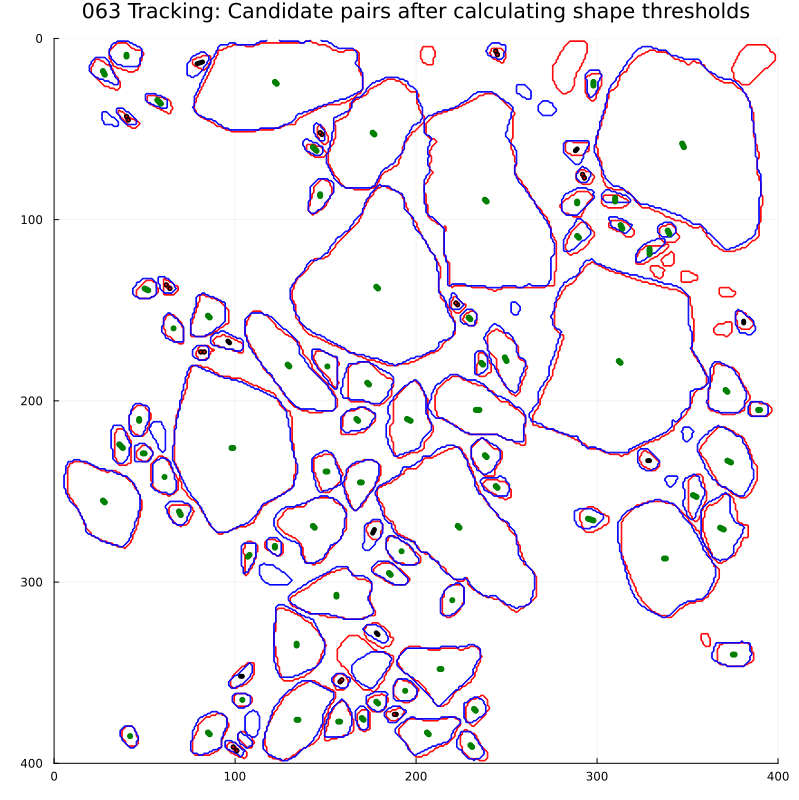

In [334]:
using Plots

plt = Plots.contour(aqua.validated_binary_floes .> 0, levels=2, color=:red, label="Aqua", legend=false, aspect_ratio=:equal, size=(800,800))
Plots.contour!(terra.validated_binary_floes .> 0, levels=2, color=:blue, label="Terra")
# Plots.scatter!(props[1][1:10,:].col_centroid, props[1][1:10,:].row_centroid, label="Included in sample")
for pair in eachrow(nearest_match[!, [:floe1_uuid, :uuid]])
    floe1_uuid = pair.floe1_uuid
    floe2_uuid = pair.uuid
    floe1 = props[1][props[1].uuid .== floe1_uuid,:]
    floe2 = props[2][props[2].uuid .== floe2_uuid,:]

    # Color the too-small floes red so we know they are missed on purpose
    0.5 * (floe1.area[1] + floe2.area[1]) < 64 ? color=:red : color = :black
    Plots.plot!([floe1.col_centroid; floe2.col_centroid], [floe1.row_centroid; floe2.row_centroid],
        linewidth=5, marker=:circle, markersize=2, color=color)
    
end

for pair in eachrow(default_test_matches[!, [:floe1_uuid, :uuid]])
    floe1_uuid = pair.floe1_uuid
    floe2_uuid = pair.uuid
    floe1 = props[1][props[1].uuid .== floe1_uuid,:]
    floe2 = props[2][props[2].uuid .== floe2_uuid,:]
    
    Plots.plot!([floe1.col_centroid; floe2.col_centroid], [floe1.row_centroid; floe2.row_centroid], linewidth=6, markersize=2, color=:green)
end

Plots.ylims!(0, 400)
Plots.xlims!(0, 400)
yflip!(true)
title!(split(aqua.name, "-")[1]*" Tracking: Candidate pairs after calculating shape thresholds")
plt

In [335]:
# Number of matches found with default method
nrow(default_test_matches)

70

In [339]:
# Total available matches
sum(nearest_match[:, :area] .> 64)

77

77

In [223]:
test_matches[:, :dxdt] = abs.(test_matches[:, :Δx] ./ [x.value for x in Second.(test_matches[:, :Δt])]);
umean = mean(test_matches.dxdt)
ustd = std(test_matches.dxdt)
subset(test_matches, :dxdt => ByRow(r -> (r - umean)/ustd < 3))

In [231]:
names(nearest_match)

20-element Vector{String}:
 "uuid"
 "floe1_uuid"
 "area"
 "min_row"
 "min_col"
 "max_row"
 "max_col"
 "row_centroid"
 "col_centroid"
 "convex_area"
 "major_axis_length"
 "minor_axis_length"
 "orientation"
 "perimeter"
 "mask"
 "passtime"
 "psi"
 "Δt"
 "Δx"
 "dxdt"

In [ ]:
# This is for a 1-day skip. Obviously kind of a mess! 
# We can look at num matches per size vs the number at each size
# and we can see how the shape difference and the psi-s curve reduce the number of potential matches. 
# Re-run the ADR tests; select a minimum size and large floe size for using Rosalinda's shape step function.

We can use a logistic function for threshold tests; it describes a bounded smooth curve with flexible parameters.
$$f(x)=\frac {L}{1+e^{-k(x-x_{0})}}$$
$L$ = supremum value  
$x_0$ = center  
$k$ = steepness parameter

In [ ]:
           
        candidate_subset = filter(r -> 

        
        if callmatchcorr(conditions)
            (area_mismatch, corr) = matchcorr(
                floe1.mask, floe2.mask, Δt; candidate_matching_settings.comp...
            )
            if isfloegoodmatch(conditions, candidate_matching_settings.goodness, area_mismatch, corr)
                @debug "** Found a good match for ", floe1.uuid, "<=", floe2.uuid
                push!(
                    matches,
                    (;
                        Δt,
                        measures=(; ratios..., area_mismatch, corr),
                        conditions,
                        dist,
                        floe1,
                        floe2,
                    ),
                )
            end
        end
    end

    remaining_matches_df = DataFrame(matches)
    best_matches = []

    for floe2 in eachrow(
        sort(candidate_props, :area; rev=true),  # prioritize larger floes
    )
        matches_involving_floe2_df = filter((r) -> r.floe2 == floe2, remaining_matches_df)
        nrow(matches_involving_floe2_df) == 0 && continue
        best_match = matches_involving_floe2_df[1, :]
        measures_df = DataFrame(matches_involving_floe2_df.measures)
        best_match_idx = getidxmostminimumeverything(measures_df) # TODO: Update this to take travel distance into account; potentially add weighing function
        best_match = matches_involving_floe2_df[best_match_idx, :]
        push!(
            best_matches,
            (;
                best_match.floe2...,
                area_mismatch=best_match.measures.area_mismatch,
                corr=best_match.measures.corr,
                trajectory_uuid=best_match.floe1.trajectory_uuid,
                head_uuid=best_match.floe1.uuid,
            ),
        )
        # Filter out from the remaining matches any cases involving the matched floe1
        remaining_matches_df = filter(
            (r) -> !(r.floe1 === best_match.floe1), remaining_matches_df
        )
        # Filter out from the remaining matches any cases involving the matched floe2
        remaining_matches_df = filter(
            (r) -> !(r.floe2 === best_match.floe2), remaining_matches_df
        )
    end

    best_matches_df = similar(tracked, 0)
    append!(best_matches_df, best_matches; promote=true)
    return best_matches_df
end

In [568]:
props[1][!, :bdry] = IceFloeTracker.bwtraceboundary.(props[1][!, :mask])
props[2][!, :bdry] = IceFloeTracker.bwtraceboundary.(props[2][!, :mask]);

# Inside the find_floe_matches function
1. `get_dt(floe1, floe2) # check times`
2. `ratios, conditions, dist = compute_ratios_conditions(floe1, floe2, deltat, condition_thresholds)`
3. `callmatchcorr(conditions)`
4. `area_mismatch, corr = matchcorr(floe1.mask, floe2.mask, deltat; mc_thresholds.comp...)`
5. `isfloegoodmatch(conditions, mc_thresholds.goodness, area_mismatch, corr)`

Questions
* Does "for floe1 in eachrow(tracked), for floe2 in eachrow(candidates)" check each pairing twice?

In [569]:
df_terra = props[1]
df_aqua = props[2]
floe1 = df_terra[argmax(df_terra[!,:area]), :]
floe2 = df_aqua[argmax(df_aqua[!,:area]), :];

# Plotting boundaries
In this figure, I use the bwtraceboundary result to draw the outlines of floes. This ideally will let us use the smaller Plots library
to visualize the results of the tracking algorithm. To plot this, we have to remember a few differences between image plots and matrix plots, in terms of which value comes first. I had to rotate and reverse the floe image, add the corners for the bounding box, and consider the second index of the floe boundaries as the X (columns) variable.

# Run the tracker

In [570]:
track_results = IceFloeTracker.long_tracker(props, ct, mc_thresholds);

In [571]:
# Note that the props dataframes are modified in place -- this is good to know so we can avoid it if necessary.
size(props[2])

(31, 17)

In [572]:
names(track_results)

22-element Vector{String}:
 "ID"
 "trajectory_uuid"
 "head_uuid"
 "uuid"
 "area"
 "min_row"
 "min_col"
 "max_row"
 "max_col"
 "row_centroid"
 "col_centroid"
 "convex_area"
 "major_axis_length"
 "minor_axis_length"
 "orientation"
 "perimeter"
 "mask"
 "passtime"
 "psi"
 "bdry"
 "area_mismatch"
 "corr"

In [689]:
# need to recalculate mismatch to not set it to zero, and need to find why the rotation isn't getting kept
number, region, dx, date, sat, res = split(terra.name, "-");
Dates.seconds(Day(15))

1296000

In [690]:
Δt = Minute(15)
Δt_medium = Hour(48)
Δt_long = Day(15)
Δx = 10
llq_params=[0.403, 0.988, -0.05]
min_time=Hour(1)
max_time=Day(7)

a, b, c = llq_params
seconds(Δt) > seconds(max_time)

false

In [691]:
Δx_km = Δx / 1000
seconds(Δt) <= seconds(min_time)

true

In [692]:
 Δx_km <= 10^a # Check whether this is being activated early. Issue with time format?

true

In [693]:
Δt_hours = seconds(Δt) / 3600
Δx_km <= 10^(a + b * log10(Δt_hours) + c * (log10(Δt_hours))^2)

true

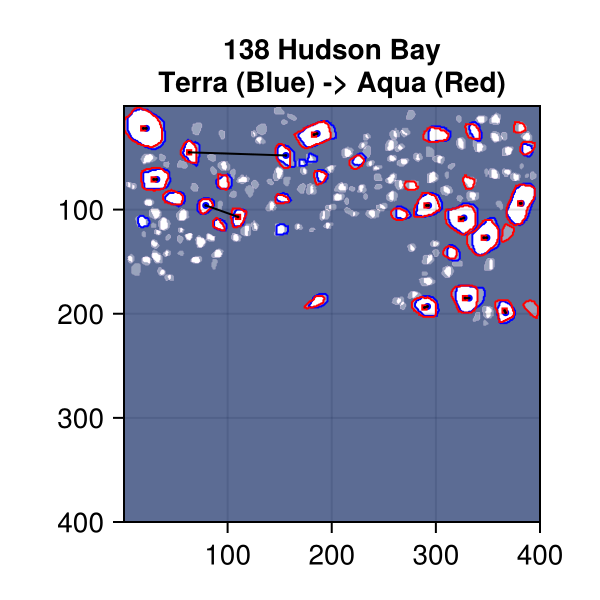

In [574]:
idx = track_results.trajectory_uuid[1]
track_data = filter(r -> r.trajectory_uuid == idx, track_results);

f = Figure(size=(300, 300))
ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title=number*" "*titlecase(replace(region, "_"=>" "))*"\nTerra (Blue) -> Aqua (Red)")
ax1.yreversed = true
floes = terra.validated_binary_floes .> 0
CairoMakie.contourf!(ax1, rotr90(reverse(floes, dims=1)), levels = 0:0.5:1, colormap=(:batlow, 0.4))   
floes = aqua.validated_binary_floes .> 0
CairoMakie.contourf!(ax1, rotr90(reverse(floes, dims=1)), levels = 0:0.5:1, colormap=(:batlow, 0.4))   
for (props_df, color) in zip(props, [:blue, :red])
    for floe_data in eachrow(props_df)
        floe = floe_data.bdry
        rc = floe_data.min_row - 1
        cc = floe_data.min_col - 1
        lines!(ax1, getindex.(floe[1], 2) .+ cc, getindex.(floe[1], 1) .+ rc, color=color, linewidth=1)
    end
end
for traj_id in unique(track_results.trajectory_uuid)
    traj_data = filter(r -> r.trajectory_uuid == traj_id, track_results);
    CairoMakie.scatter!(ax1, first(traj_data.col_centroid), first(traj_data.row_centroid), marker=:circle, markersize=5, color=:blue)
    CairoMakie.scatter!(ax1, last(traj_data.col_centroid), last(traj_data.row_centroid), marker=:rect, markersize=5, color=:red)
    scatterlines!(ax1, traj_data.col_centroid, traj_data.row_centroid, marker=:circle, markersize=2, color=:black, linewidth=1)
end
CairoMakie.ylims!(400, 0.5)
CairoMakie.xlims!(0.5, 400)
current_figure()


# Follow-up questions
1. What difference is there between the true matches and the mismatches? What tends to be true about the outliers?
   * In this image in particular, the outliers are unrealistically far -- the implied drift speed would be much too high. However in other cases we would not be able to make that assumption.
   * Many of these are cases where there is no true match -- no match was detected.
3. How often do we get multiple matches? (I think it's circular matches actually -- a mixup for 1 links to 2 and 2 links to 1.)
   * What can we do to evaluate the quality of the matches? Is the psi-s correlation enough?
   * The smallest correlation in the matches is 97%, and we know from other parts of the analysis that the correlation can be high for non-matches.
   * How good is the mismatch function? It can only work well if the centroid is placed properly.
   * How can we juggle the set of best matches?
4. How does uncertainty in psi-s change the result? In particular if I add the confidence intervals from the dev version of IFT, how many potential matches are there?

In [342]:
CSV.write("../data/case_006_tracker_results.csv", track_results[!, [c for c in names(track_results) if c ∉ ["mask", "psi", "bdry"]]])

"../data/case_006_tracker_results.csv"

In [327]:
# groupby trajectory and get the distance between the image pairs
gdf = groupby(track_results, :trajectory_uuid);
df_endpoints = combine(gdf, last);

# initialize column
distances = []
for traj_id in df_endpoints.trajectory_uuid
    traj_data = filter(r -> r.trajectory_uuid == traj_id, track_results)
    append!(distances, round(IceFloeTracker.dist(traj_data[1, :], traj_data[2,:]), digits=1))
end
df_endpoints[!, :distance] = distances;

In [341]:
names(track_results)

22-element Vector{String}:
 "ID"
 "trajectory_uuid"
 "head_uuid"
 "uuid"
 "area"
 "min_row"
 "min_col"
 "max_row"
 "max_col"
 "row_centroid"
 "col_centroid"
 "convex_area"
 "major_axis_length"
 "minor_axis_length"
 "orientation"
 "perimeter"
 "mask"
 "passtime"
 "psi"
 "bdry"
 "area_mismatch"
 "corr"

In [333]:
large_displacements = filter(r -> r.distance > 100, df_endpoints);
large_displacements[!, ["trajectory_uuid", "area", "distance", "area_mismatch", "corr"]]

Row,trajectory_uuid,area,distance,area_mismatch,corr
,String,Float64,Any,Float64?,Float64?
1,1RtN1qQXviCA,457.0,157.7,0.0,0.97311
2,1eOxdG73vNBx,430.0,171.9,0.0,0.98818
3,2b6SPrVWB1Vj,374.0,174.0,0.0,0.997357
4,3nEZ883J0arg,365.0,192.4,0.0,0.992352
5,3wt9AycUssPD,521.0,106.6,0.0,0.971808
6,4BNQ3go2LHWb,317.0,151.8,0.0,0.983873
7,7vxXf9G8Mo1s,214.0,136.9,0.0,0.982945
8,88WLq4SPHQk4,665.0,151.2,0.0,0.992933
9,8OUS1GCKfHAp,234.0,173.6,0.0,0.990184


In [307]:
# check potential idea of checking for feature match using floes as templates with Orb or BRISK
import Pkg; Pkg.add("ImageFeatures")
using ImageFeatures

   Resolving package versions...
   Installed ImageFeatures ─ v0.5.3
    Updating `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val/Project.toml`
  [92ff4b2b] + ImageFeatures v0.5.3
    Updating `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val/Manifest.toml`
  [92ff4b2b] + ImageFeatures v0.5.3
Precompiling project...
   3838.1 ms  ✓ ImageFeatures
  1 dependency successfully precompiled in 6 seconds. 505 already precompiled.


In [251]:
sort(track_results[!, ["area", "trajectory_uuid", "uuid", "area_mismatch", "corr"]], "corr")

Row,area,trajectory_uuid,uuid,area_mismatch,corr
,Float64,String,String,Float64?,Float64?
1,521.0,3wt9AycUssPD,JCty0VVYN3rk,0.0,0.971808
2,457.0,1RtN1qQXviCA,EsVrhMTgtf4r,0.0,0.97311
3,455.0,fGDRzkTegfsq,acBoAymnPBUg,0.0,0.980183
4,694.0,4F68vGZJ4PVN,3Xb6cpS2t5Go,0.0,0.981837
5,214.0,7vxXf9G8Mo1s,A9OqtDt3NDIA,0.0,0.982945
6,317.0,4BNQ3go2LHWb,6iZkTY1suVQo,0.0,0.983873
7,555.0,vozaVez79z9Y,9wAuPDURF7l9,0.0,0.984076
8,306.0,KbzYpEft7mbz,Wqp1q8vVuZRv,0.0,0.984644
9,362.0,RmoBJXRjyQjl,ukVzeLfCsvqf,0.0,0.985205


# Visualizing tracker results

In [103]:
# It actually worked to do bwtraceboundary on the full image, though that's not the intended usage.
floes = aqua.validated_binary_floes .> 0
bdry = IceFloeTracker.bwtraceboundary(rotr90(floes));

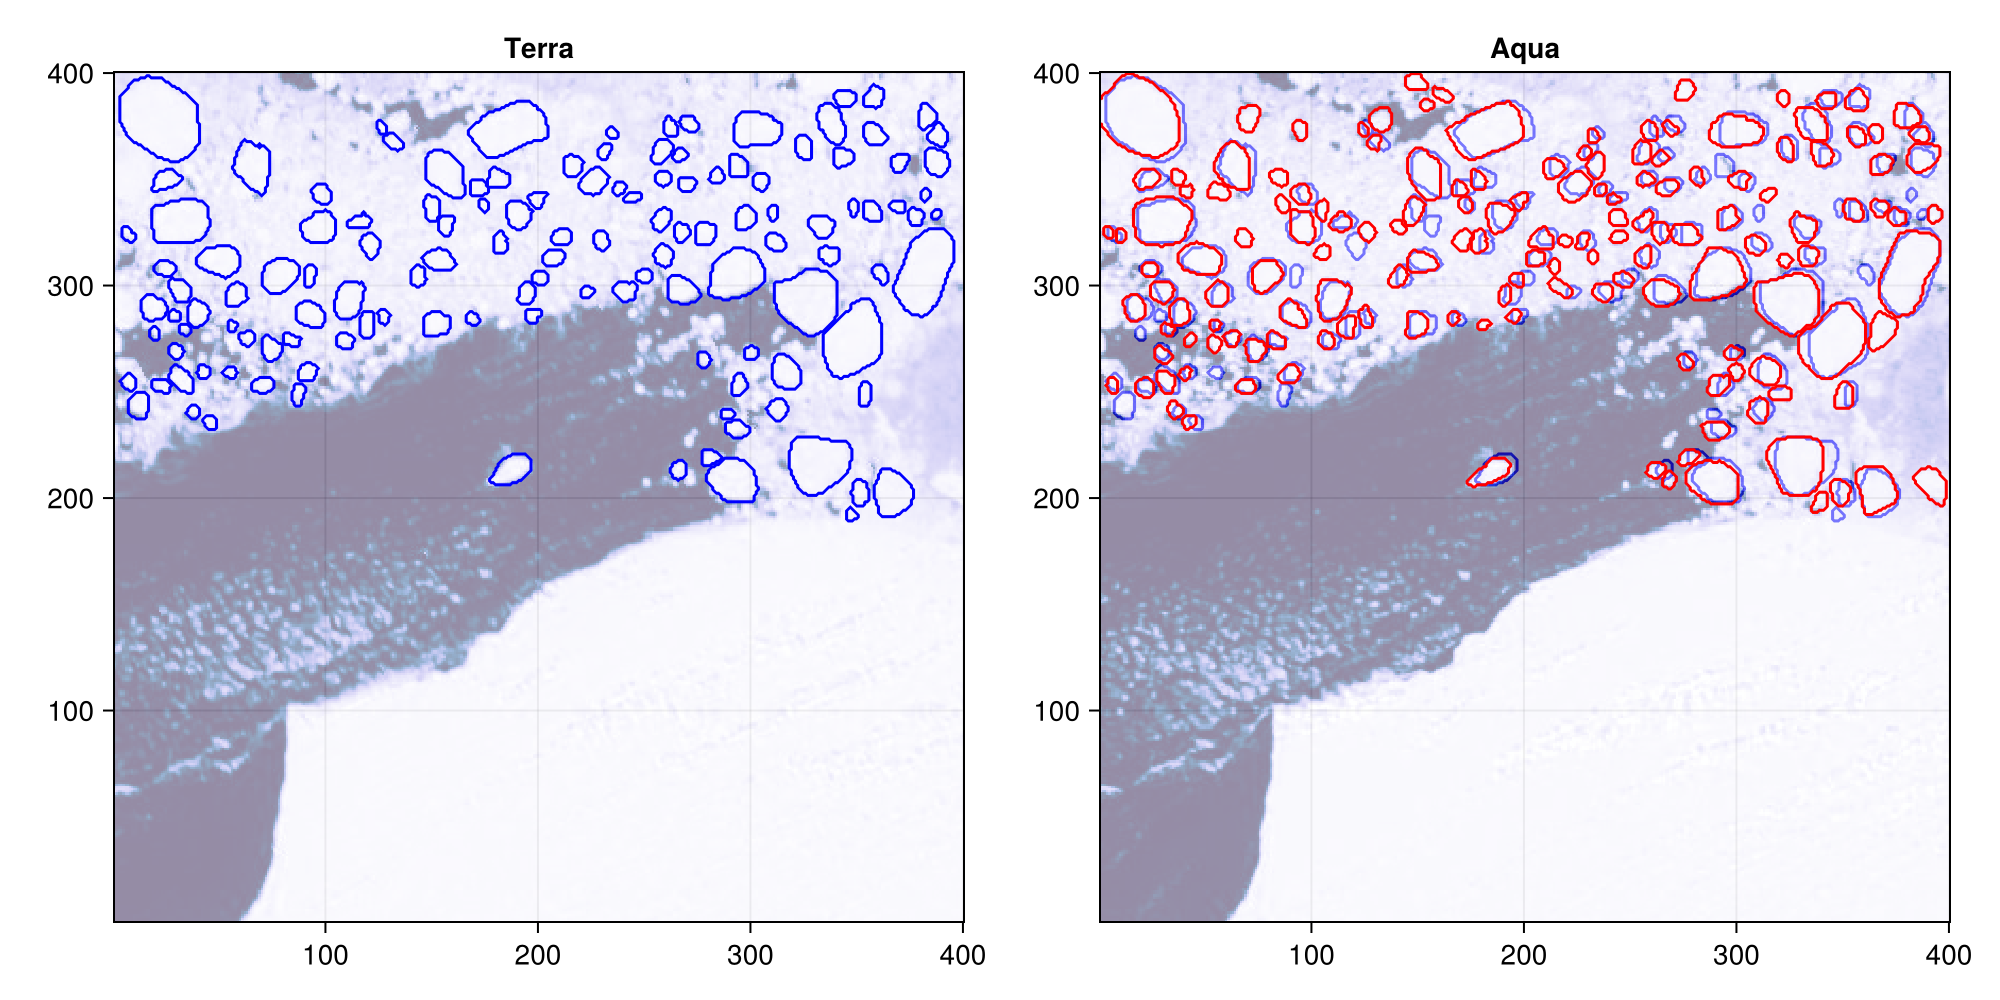

CairoMakie.Screen{IMAGE}


In [667]:
# color options: https://docs.makie.org/dev/explanations/colors

# force Jupyter to use PNG to speed up plotting
CairoMakie.enable_only_mime!("png")

# Initialize figure object
f = Figure(size=(1000, 500))

# Add two panels and give them titles
ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="Terra")
ax2 = CairoMakie.Axis(f[1, 2], aspect = 1, title="Aqua")

# Plot the Terra data. First, we get the binary floes as a bitmatrix
floes = terra.validated_binary_floes .> 0

# Then we plot the image using the "heatmap" function. Here I'm using Band 2 which has
# high contrast between water and ice.
CairoMakie.heatmap!(ax1, rotr90(green.(terra.modis_falsecolor)), 
        colormap=(:devon, 0.5), colorrange=(0, 1))

# Now we draw the Terra floe outlines using a contour plot. This method draws lines at
# places where the image gradient is large. In a binary image, it's all 0 or 1, so using
# levels = 0, 0.5, 1 forces it to draw lines along the edges of bright spots.
# Notice we draw the Terra floes on both images here by specificy ax1 and ax2.
CairoMakie.contour!(ax1, rotr90(floes), color = :blue, levels = 0:0.5:1)   
CairoMakie.contour!(ax2, rotr90(floes), color = :blue, levels = 0:0.5:1)   

# Now do the same for the Aqua images
floes = aqua.validated_binary_floes .> 0
CairoMakie.heatmap!(ax2, rotr90(green.(aqua.modis_falsecolor)), 
        colormap=(:devon, 0.5), colorrange=(0, 1))
CairoMakie.contour!(ax2, rotr90(floes), color = :red, levels = 0:0.5:1)   

# Finally we show the figure.
# We could also save it with the command save("image_name.png", f)
display(f)

In [30]:
 
# for floe in bdry
#     lines!(ax1, getindex.(floe, 1), getindex.(floe, 2), color=:red)
# end
